In [515]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import os
import time

import matplotlib.pyplot as plt
import theano
import math
import numpy as np
import pandas as pd
import cPickle as pickle
# Implicit import needed in newer theano versions
# https://groups.google.com/forum/#!msg/lasagne-users/gEtFrC8mkms/0oNCDbSKbTkJ
import lasagne.layers.cuda_convnet

from lasagne import layers
# use the cuda-convnet implementations of conv and max-pool layer
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from collections import OrderedDict
from sklearn.base import clone

In [516]:
# Input directory and files
DATA_DIR = '/home/ubuntu/data/'
F_TRAIN = DATA_DIR + 'training.csv'
F_TEST = DATA_DIR + 'test.csv'
F_LOOKUP_TABLE = DATA_DIR + 'IdLookupTable.csv'

FEATURES = list(read_csv(F_TRAIN, nrows = 1).columns.values[:-1])
LOOKUP_DF = read_csv(F_LOOKUP_TABLE)
# It's just a column with NaN. Location will be added from predicted data.
LOOKUP_DF.drop('Location', 1, inplace = True)
for i in range(len(FEATURES)):
    print i, ") ", FEATURES[i]

# Output directory and files
SUB_DIR = '/home/ubuntu/training/'
MODEL_DIR = '/home/ubuntu/training/'

0 )  left_eye_center_x
1 )  left_eye_center_y
2 )  right_eye_center_x
3 )  right_eye_center_y
4 )  left_eye_inner_corner_x
5 )  left_eye_inner_corner_y
6 )  left_eye_outer_corner_x
7 )  left_eye_outer_corner_y
8 )  right_eye_inner_corner_x
9 )  right_eye_inner_corner_y
10 )  right_eye_outer_corner_x
11 )  right_eye_outer_corner_y
12 )  left_eyebrow_inner_end_x
13 )  left_eyebrow_inner_end_y
14 )  left_eyebrow_outer_end_x
15 )  left_eyebrow_outer_end_y
16 )  right_eyebrow_inner_end_x
17 )  right_eyebrow_inner_end_y
18 )  right_eyebrow_outer_end_x
19 )  right_eyebrow_outer_end_y
20 )  nose_tip_x
21 )  nose_tip_y
22 )  mouth_left_corner_x
23 )  mouth_left_corner_y
24 )  mouth_right_corner_x
25 )  mouth_right_corner_y
26 )  mouth_center_top_lip_x
27 )  mouth_center_top_lip_y
28 )  mouth_center_bottom_lip_x
29 )  mouth_center_bottom_lip_y


In [552]:
def float32(k):
    return np.cast['float32'](k)

def load(test=False, cols=None, drop_na = True):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = F_TEST if test else F_TRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    #print(df.count())  # prints the number of values for each column
    if drop_na:
        df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


def load2d(test=False, cols=None, drop_na = True):
    X, y = load(test=test, cols=cols, drop_na = drop_na)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

def evaluate(net, csv=False, out_file='sub.csv'):
    X_test, _ = load(test=True)
    return evaluate_internal(net.predict(X_test), csv, out_file)

def evaluate2d(net, csv=False, out_file='sub.csv'):
    X_test, _ = load2d(test=True)
    return evaluate_internal(net.predict(X_test), csv, out_file)

def evaluate_internal(y_pred, csv, out_file):
    y_pred = y_pred*48 + 48
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df.columns = FEATURES
    y_pred_df['ImageId'] = range(1, len(y_pred_df) + 1)
    if (csv):
        melt_pred = pd.melt(y_pred_df, id_vars = ['ImageId'], var_name = 'FeatureName', value_name = 'Location')
        merged = LOOKUP_DF.merge(melt_pred, how = 'left')
        merged.drop(['ImageId', 'FeatureName'], 1, inplace = True)
        merged.to_csv(SUB_DIR + out_file, index = False)
    return y_pred_df

def calc_rmse(y, y_pred):
    se = np.sum((y - y_pred)**2)
    mse = se / (y.shape[0] * y.shape[1])
    return math.sqrt(mse)

def plot_losses(net, range):
    plt.figure('', (8, 8))
    train, = plt.plot([x['epoch'] for x in net.train_history_], [x['train_loss'] for x in net.train_history_])
    valid, = plt.plot([x['epoch'] for x in net.train_history_], [x['valid_loss'] for x in net.train_history_])
    plt.legend([train, valid], ['train_loss', 'valid_loss'])
    plt.axis(range)

In [518]:
# Load data
X1, y1 = load()
print X1.shape
print y1.shape

# Load 2-d data
X2, y2 = load2d()
print "2d data"
print X2.shape
print y2.shape

(2140, 9216)
(2140, 30)
2d data
(2140, 1, 96, 96)
(2140, 30)


In [519]:
# Load all data, don't skip rows with 'nan'
X_full, y_full = load2d(drop_na = False)
print X_full.shape
print y_full.shape

(7049, 1, 96, 96)
(7049, 30)


In [193]:
## DEBUG 
count = 0
tmp = []
print len(y_full)
for x in y_full:
    if not(np.isnan(x[0]) or np.isnan(x[1])):
        count += 1
    else:
        tmp.append(x)
print count
## DEBUG 

7049
7039


In [15]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [6]:
class AdjustVariable(object):
    def __init__(self, name, start, stop):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [5]:
class HorizontalFlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(HorizontalFlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
  

## Simple neural network
- Single hidden layer, 100 nodes

In [6]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(128, 9216),  # 128 images per batch times 96x96 input pixels
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

In [137]:
start_time = time.time()
net1.fit(X1, y1)
print("Run time = {0}".format(int(time.time() - start_time)))
_ = evaluate(net2, csv = True, out_file = 'net1_400_epoch.csv')

with open(MODEL_DIR + 'net1_400_epoch.pickle', 'wb') as f:
    pickle.dump(net1, f, -1)

  input             	(128, 9216)         	produces    9216 outputs
  hidden            	(128, 100)          	produces     100 outputs
  output            	(128, 30)           	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.16271       0.03813      4.26752  0.07s
      2       0.02549       0.01766      1.44338  0.07s
      3       0.01443       0.01440      1.00189  0.07s
      4       0.01269       0.01333      0.95147  0.07s
      5       0.01181       0.01253      0.94263  0.07s
      6       0.01113       0.01194      0.93212  0.07s
      7       0.01064       0.01148      0.92654  0.07s
      8       0.01025       0.01110      0.92350  0.07s
      9       0.00992       0.01077      0.92162  0.07s
     10       0.00965       0.01048      0.92014  0.07s
     11       0.00940       0.01023      0.91910  0.07s
     12       0.00919       0.01001      0.91832  0.06s
     13       0.0

## Convolution

3 layers convolution layers w\ max pooling (2 x 2)
- 32 x 3 x 3
- 64 x 2 x 2
- 128 x 2 x 2

2 hidden layers. 500 nodes each.


In [7]:
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(128, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=500,
    verbose=1,
    )

In [140]:
start_time = time.time()
net2.fit(X2, y2)
print("Run time = {0}".format(int(time.time() - start_time)))
_ = evaluate2d(net2, csv = True, out_file = 'net2_500_epoch.csv')

# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:pickle
with open(MODEL_DIR + 'net2_1000_epoch.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

  input             	(128, 1, 96, 96)    	produces    9216 outputs
  conv1             	(128, 32, 94, 94)   	produces  282752 outputs
  pool1             	(128, 32, 47, 47)   	produces   70688 outputs
  conv2             	(128, 64, 46, 46)   	produces  135424 outputs
  pool2             	(128, 64, 23, 23)   	produces   33856 outputs
  conv3             	(128, 128, 22, 22)  	produces   61952 outputs
  pool3             	(128, 128, 11, 11)  	produces   15488 outputs
  hidden4           	(128, 500)          	produces     500 outputs
  hidden5           	(128, 500)          	produces     500 outputs
  output            	(128, 30)           	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.10054       0.03099      3.24435  1.87s
      2       0.01608       0.01007      1.59674  1.87s
      3       0.00879       0.00805      1.09278  1.86s
      4       0.00742       0.00746      0.99490  1.

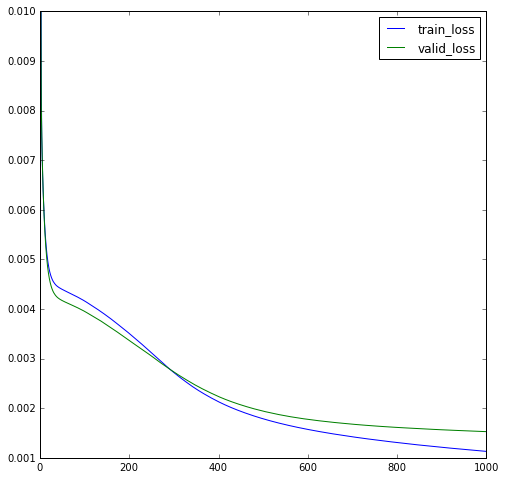

In [47]:
plot_losses(net2, [0, 1000, 0.001, 0.01])

## Convolution + Augmentation (flip)

In [14]:
NET3_NUM_EPOCHS = 3000

net3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(128, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    batch_iterator_train=HorizontalFlipBatchIterator(batch_size=128),
    max_epochs=NET3_NUM_EPOCHS,
    verbose=1,
    )

In [24]:
start_time = time.time()
net3.fit(X2, y2)
print("Run time = {0}".format(int(time.time() - start_time)))
_ = evaluate2d(net3, csv = True, out_file = 'net3_' + str(NET3_NUM_EPOCHS) + '_epoch.csv')

with open(MODEL_DIR + 'net3_' + str(NET3_NUM_EPOCHS) + '_epoch.pickle', 'wb') as f:
    pickle.dump(net3, f, -1)

  input             	(128, 1, 96, 96)    	produces    9216 outputs
  conv1             	(128, 32, 94, 94)   	produces  282752 outputs
  pool1             	(128, 32, 47, 47)   	produces   70688 outputs
  conv2             	(128, 64, 46, 46)   	produces  135424 outputs
  pool2             	(128, 64, 23, 23)   	produces   33856 outputs
  conv3             	(128, 128, 22, 22)  	produces   61952 outputs
  pool3             	(128, 128, 11, 11)  	produces   15488 outputs
  hidden4           	(128, 500)          	produces     500 outputs
  hidden5           	(128, 500)          	produces     500 outputs
  output            	(128, 30)           	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.10930       0.03752      2.91312  2.09s
      2       0.01668       0.00948      1.75984  2.09s
      3       0.00862       0.00793      1.08698  2.07s
      4       0.00735       0.00748      0.98216  2.

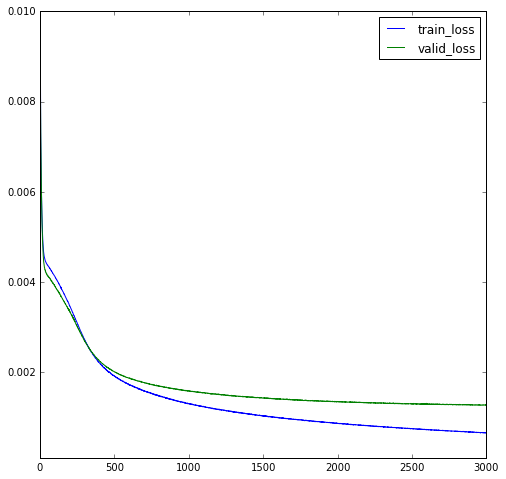

In [48]:
plot_losses(net3, [0, 3000, 0.0001, 0.01])

## Faster learning using varying learning rate and momentum

In [20]:
# Also set learning_rate's and momentum's start and stop correctly.
NET5_NUM_EPOCHS = 3000

net5 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(128, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=HorizontalFlipBatchIterator(batch_size=128),
    max_epochs=NET5_NUM_EPOCHS,
    on_epoch_finished= [
        AdjustVariable('update_learning_rate', start=0.03, stop=0.001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
    ],
    verbose=1,
    )

In [41]:
start_time = time.time()
net5.fit(X2, y2)
print("Run time = {0}".format(int(time.time() - start_time)))
_ = evaluate2d(net5, csv = True, out_file = 'net5_' + str(NET5_NUM_EPOCHS) + '_epoch.csv')

with open(MODEL_DIR + 'net5_' + str(NET5_NUM_EPOCHS) + '_epoch.pickle', 'wb') as f:
    pickle.dump(net5, f, -1)

  input             	(128, 1, 96, 96)    	produces    9216 outputs
  conv1             	(128, 32, 94, 94)   	produces  282752 outputs
  pool1             	(128, 32, 47, 47)   	produces   70688 outputs
  conv2             	(128, 64, 46, 46)   	produces  135424 outputs
  pool2             	(128, 64, 23, 23)   	produces   33856 outputs
  conv3             	(128, 128, 22, 22)  	produces   61952 outputs
  pool3             	(128, 128, 11, 11)  	produces   15488 outputs
  hidden4           	(128, 500)          	produces     500 outputs
  hidden5           	(128, 500)          	produces     500 outputs
  output            	(128, 30)           	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.06663       0.00864      7.71458  2.09s
      2       0.00777       0.00635      1.22418  2.11s
      3       0.00595       0.00559      1.06475  2.11s
      4       0.00544       0.00519      1.04724  2.

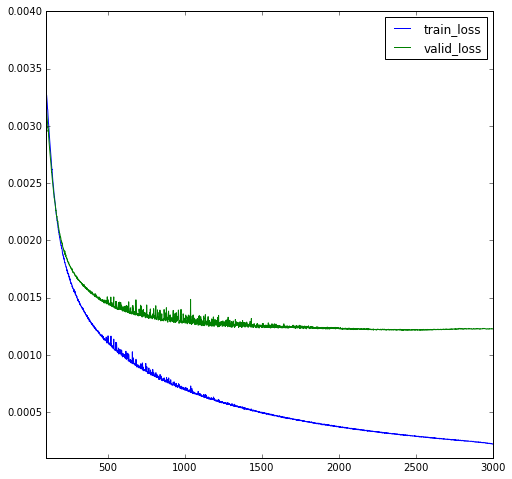

In [49]:
plot_losses(net5, [100, 3000, 0.0001, 0.004])

## With dropouts

In [28]:
NET6_NUM_EPOCHS = 3000

net6 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=HorizontalFlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=NET6_NUM_EPOCHS,
    verbose=1,
    )

In [29]:
import sys
# To prevent pickle from failing with maximum recursion error.
sys.setrecursionlimit(10000)

start_time = time.time()
net6.fit(X2, y2)
print("Run time = {0}".format(int(time.time() - start_time)))
_ = evaluate2d(net6, csv = True, out_file = 'net6_' + str(NET6_NUM_EPOCHS) + '_epoch.csv')

with open(MODEL_DIR + 'net6_' + str(NET6_NUM_EPOCHS) + '_epoch.pickle', 'wb') as f:
    pickle.dump(net6, f, -1)

  input             	(None, 1, 96, 96)   	produces    9216 outputs
  conv1             	(None, 32, 94, 94)  	produces  282752 outputs
  pool1             	(None, 32, 47, 47)  	produces   70688 outputs
  dropout1          	(None, 32, 47, 47)  	produces   70688 outputs
  conv2             	(None, 64, 46, 46)  	produces  135424 outputs
  pool2             	(None, 64, 23, 23)  	produces   33856 outputs
  dropout2          	(None, 64, 23, 23)  	produces   33856 outputs
  conv3             	(None, 128, 22, 22) 	produces   61952 outputs
  pool3             	(None, 128, 11, 11) 	produces   15488 outputs
  dropout3          	(None, 128, 11, 11) 	produces   15488 outputs
  hidden4           	(None, 1000)        	produces    1000 outputs
  dropout4          	(None, 1000)        	produces    1000 outputs
  hidden5           	(None, 1000)        	produces    1000 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
------- 

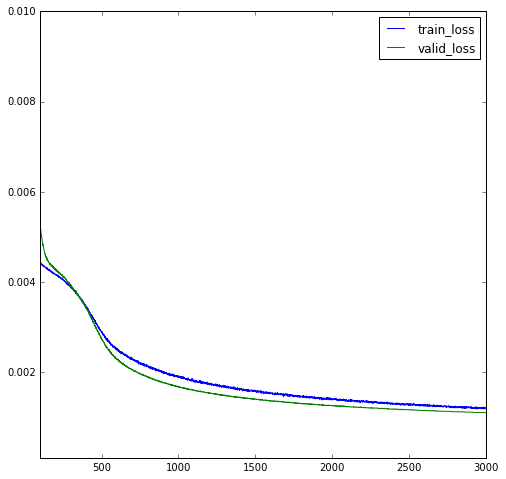

In [51]:
plot_losses(net6, [100, 3000, 0.0001, 0.01])

## Specialists

In [630]:
net7 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30,
    output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=HorizontalFlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience = 200),
        ],
    max_epochs=0,
    verbose=1,
    )

In [631]:
# Note all even indexes shoule be x coordinates since they are flipped.
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        name = 'eye_center',
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        name = 'nose_tip',
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        name = 'mouth',
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        name = 'eye_corner',
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        name = 'eyebrow',
        ),
    ]

In [632]:
def fit_specialists():
    specialists = OrderedDict()
    
    with open(MODEL_DIR + 'net6_3000_epoch.pickle', 'rb') as f:
        net_pretrain = pickle.load(f)

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net7)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        # set number of epochs relative to number of training examples:
        model.max_epochs = int(1e7 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        # Use pretrained to initialize the weights of our new specialist model
        model.load_params_from(net_pretrain)

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        print "X = ", X.shape, "   y = ", y.shape
        model.fit(X, y)
        specialists[cols] = model
        
        with open(MODEL_DIR + 'specialist_' + setting['name'] + '.pickle', 'wb') as f:
            pickle.dump(model, f, -1)

    with open(MODEL_DIR + 'net-specialists.pickle', 'wb') as f:
        # we persist a dictionary with all models:
        pickle.dump(specialists, f, -1)

In [633]:
path = '/home/ubuntu/vol2/w207/models/specialists/'
specialists = OrderedDict()
for setting in SPECIALIST_SETTINGS:
    with open(path + 'specialist_' + setting['name'] + '.pickle', 'r') as f:
        specialists[setting['columns']] = pickle.load(f)

  input             	(None, 1, 96, 96)   	produces    9216 outputs
  conv1             	(None, 32, 94, 94)  	produces  282752 outputs
  pool1             	(None, 32, 47, 47)  	produces   70688 outputs
  dropout1          	(None, 32, 47, 47)  	produces   70688 outputs
  conv2             	(None, 64, 46, 46)  	produces  135424 outputs
  pool2             	(None, 64, 23, 23)  	produces   33856 outputs
  dropout2          	(None, 64, 23, 23)  	produces   33856 outputs
  conv3             	(None, 128, 22, 22) 	produces   61952 outputs
  pool3             	(None, 128, 11, 11) 	produces   15488 outputs
  dropout3          	(None, 128, 11, 11) 	produces   15488 outputs
  hidden4           	(None, 1000)        	produces    1000 outputs
  dropout4          	(None, 1000)        	produces    1000 outputs
  hidden5           	(None, 1000)        	produces    1000 outputs
  output            	(None, 4)           	produces       4 outputs
  input             	(None, 1, 96, 96)   	produces    9216 out

In [597]:
X_test, _ = load2d(test = True)
y_pred = np.zeros((len(X_test), 30))
for setting in SPECIALIST_SETTINGS:
    model = specialists[setting['columns']]
    tmp = model.predict(X_test)
    for i in range(0, len(setting['columns'])):
        original_index = FEATURES.index(setting['columns'][i])
        y_pred[:, original_index] = tmp[:, i]

_ = evaluate_internal(y_pred, csv = True, out_file = 'specialists.csv')

[0, 5000, 0.0001, 0.005]

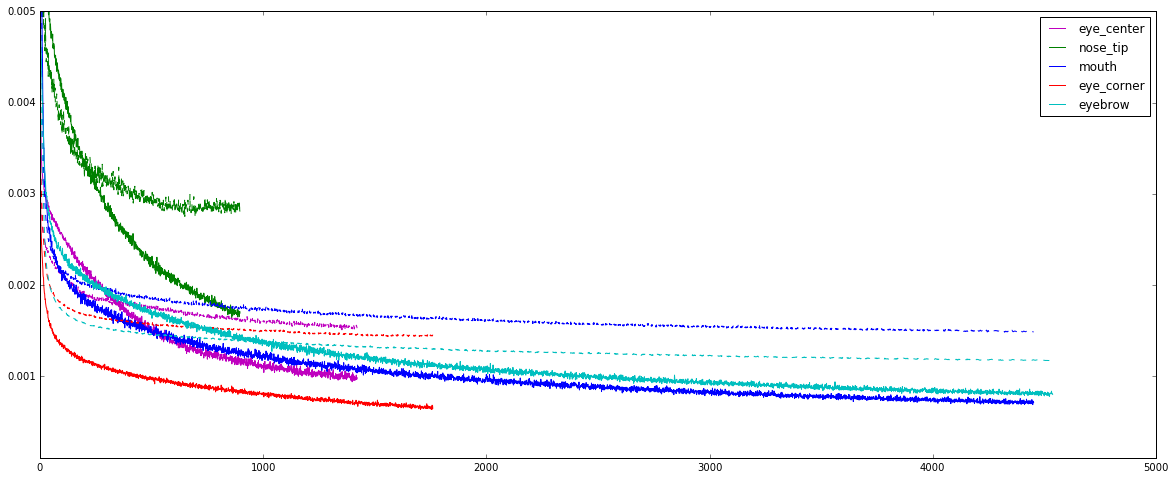

In [33]:
plt.figure('', (20, 8))
colors = ['m', 'g', 'b', 'r', 'c']
color_iter = 0
legend = []
labels = []
for setting in SPECIALIST_SETTINGS:
    model = specialists[setting['columns']]
    color = colors[color_iter]
    train, = plt.plot([x['epoch'] for x in model.train_history_], [x['train_loss'] for x in model.train_history_], color + '-')
    plt.plot([x['epoch'] for x in model.train_history_], [x['valid_loss'] for x in model.train_history_], color + '--')
    legend.append(train)
    labels.append(setting['name'])
    color_iter += 1
    
plt.legend(legend, labels)
plt.axis([0, 5000, 0.0001, 0.005])

# Super specialists

In [604]:
class Rot90BatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        Xb, yb = super(Rot90BatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 3, replace=False)
        for index in indices:
            Xb[index, 0] = np.rot90(Xb[index, 0])
            if yb is not None:
                new_x = -1 * yb[index][1]
                new_y = yb[index][0]
                yb[index][0] = new_x
                yb[index][1] = new_y

        return Xb, yb

# Vertical Flip
class VFBatchIterator(Rot90BatchIterator):
    def transform(self, Xb, yb):
        return Xb, yb
        Xb, yb = super(VFBatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 3, replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Vertically flip of y coordinate
            yb[indices, 1] *= -1

        return Xb, yb

# Horizontal Flip
class HFBatchIterator(VFBatchIterator):
    def transform(self, Xb, yb):
        return Xb, yb
        Xb, yb = super(HFBatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 3, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of x coordinate
            yb[indices, 0] *= -1

        return Xb, yb

In [627]:
PATCH_SIZE = 20
ss_net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer), 
        #('conv3', layers.Conv2DLayer),
        #('pool3', layers.MaxPool2DLayer),
        #('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        #('dropout5', layers.DropoutLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PATCH_SIZE, PATCH_SIZE),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.2,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.4,
    #conv3_num_filters=64, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    #dropout3_p=0.3,
    hidden4_num_units=300,
    dropout4_p=0.4,
    hidden5_num_units=100,
    output_num_units=2,
    output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.1)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=HFBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
        AdjustVariable('update_momentum', start=0.999, stop=0.999),
        EarlyStopping(patience = 100),
        ],
    max_epochs=1000,
    verbose=1,
    )

In [668]:
np.random.seed(7)
class SuperSpecialists:
    NUM_FEATURES = 15
    PATCH_SIZE = PATCH_SIZE
    FUZZ_SIZE = 5  # Shift center point by FUZZ_SIZE in +ve or -ve direction
    
    # Array of models
    super_specialists = []
    
    # centers is array of (x, y) points in pixels.
    def crop(self, images, centers):
        assert len(images) == len(centers)
        result = np.zeros((len(images), 1, self.PATCH_SIZE, self.PATCH_SIZE), dtype='float32')
        #result = []
        for i in range(len(images)):
            x = (int)(centers[i][0])
            y = (int)(centers[i][1])
            for k in range(self.PATCH_SIZE):
                for l in range(self.PATCH_SIZE):
                    yy = y - self.PATCH_SIZE/2 + k
                    if yy < 0 or yy > 95:
                        continue
                    xx = x - self.PATCH_SIZE/2 + l
                    if xx < 0 or xx > 95:
                        continue
                    result[i, 0, k, l] = images[i, 0, yy, xx]
        """
        # Print a sample of cropped images
        count = 0
        plt.figure('', (20, 20))
        for i in range(0, 25):
            count += 1
            plt.subplot(5,5, count)
            plt.imshow(result[i][0], cmap=plt.cm.gray)
        """
        return result
    
    # y are in the range [-1, +1]
    def fit(self, X, y):
        START = 0
        END = 15  # excluded
        #for i in range(START, self.NUM_FEATURES):
        for i in range(START, END):
            print "Fitting model for feature number ", i
            
            # Take x and y points for this feature as center for cropping
            centers = y[:, 2*i : 2*i + 2]  # Last index is ignored
            centers = centers * 48 + 48  # Translate to pixels
            filter_mask = np.any(np.isnan(centers), axis = 1)
            centers = centers[~filter_mask]
            X_new = X[~filter_mask]
            
            fuzz = np.random.rand(len(centers), 2)
            fuzz = fuzz * 2 * self.FUZZ_SIZE - self.FUZZ_SIZE
            centers = np.add(centers, fuzz)

            X_new = self.crop(X_new, centers)
            print "Num images used = ", len(X_new)
            y_new = np.array(fuzz, dtype = 'float32')
            y_new = (y_new * -1 ) / (self.PATCH_SIZE / 2)

            model = clone(ss_net)
            model.fit(X_new, y_new)
            self.super_specialists.append(model)
            with open(MODEL_DIR + 'super_specialist_' + str(i) + '.pickle', 'wb') as f:
                pickle.dump(model, f, -1)
                
    def load_from_disk(self, path):
        for i in range(self.NUM_FEATURES):
            with open(MODEL_DIR + 'super_specialist_' + str(i) + '.pickle', 'r') as f:
                self.super_specialists.append(pickle.load(f))
            
    def predict(self, X, y_hint):
        y_final = y_hint        
        assert len(self.super_specialists) == self.NUM_FEATURES
        
        for i in range(self.NUM_FEATURES):
            print "Predicting for feature number ", i
            
            centers = y_hint[:, 2*i : 2*i+2]  # Last index is ignored
            centers = centers * 48 + 48
            X_new = self.crop(X, centers)
            y_pred = self.super_specialists[i].predict(X_new)
            y_diff = (y_pred * self.PATCH_SIZE/2) / 48
            y_final[:,2*i:2*i+2] += y_diff 
        return y_final

In [669]:
ss = SuperSpecialists()
ss.load_from_disk('/home/ubuntu/training/')

  input             	(None, 1, 20, 20)   	produces     400 outputs
  conv1             	(None, 32, 18, 18)  	produces   10368 outputs
  pool1             	(None, 32, 9, 9)    	produces    2592 outputs
  dropout1          	(None, 32, 9, 9)    	produces    2592 outputs
  conv2             	(None, 64, 8, 8)    	produces    4096 outputs
  pool2             	(None, 64, 4, 4)    	produces    1024 outputs
  dropout2          	(None, 64, 4, 4)    	produces    1024 outputs
  hidden4           	(None, 300)         	produces     300 outputs
  dropout4          	(None, 300)         	produces     300 outputs
  hidden5           	(None, 100)         	produces     100 outputs
  output            	(None, 2)           	produces       2 outputs
  input             	(None, 1, 20, 20)   	produces     400 outputs
  conv1             	(None, 32, 18, 18)  	produces   10368 outputs
  pool1             	(None, 32, 9, 9)    	produces    2592 outputs
  dropout1          	(None, 32, 9, 9)    	produces    2592 out

In [663]:
X_test, _ = load2d(test = True)
y_hint = np.zeros((len(X_test), 30))
for setting in SPECIALIST_SETTINGS:
    model = specialists[setting['columns']]
    tmp = model.predict(X_test)
    for i in range(0, len(setting['columns'])):
        original_index = FEATURES.index(setting['columns'][i])
        y_hint[:, original_index] = tmp[:, i]

In [670]:
y_pred = ss.predict(X_test, y_hint)
        
_ = evaluate_internal(y_pred, csv = True, out_file = 'specialists.csv')

Predicting for feature number  0
Predicting for feature number  1
Predicting for feature number  2
Predicting for feature number  3
Predicting for feature number  4
Predicting for feature number  5
Predicting for feature number  6
Predicting for feature number  7
Predicting for feature number  8
Predicting for feature number  9
Predicting for feature number  10
Predicting for feature number  11
Predicting for feature number  12
Predicting for feature number  13
Predicting for feature number  14


In [662]:
print len(X_test), len(y_hint)

1783 1783


In [598]:
# DEBUG
model1 = specialists[SPECIALIST_SETTINGS[0]['columns']]
model2 = ss.super_specialists[0]
# DEBUG

In [618]:
filter_mask = np.any(np.isnan(y_full[:,:2]), axis = 1)
X_filter = X_full[~filter_mask]
y_filter = y_full[~filter_mask][:,:2]
print "num points = ", len(y_filter)
yy_pred = model1.predict(X_filter)
yy_pred = yy_pred[:,:2]  # Only get data for left eye center
print "rmse model 1 = ", calc_rmse(yy, yy_pred)

num points =  7039
rmse model 1 =  0.0295217572951


In [620]:
centers = yy_pred[:,:2]
centers = centers * 48 + 48
XX_new = ss.crop(XX, centers)
tmp = model2.predict(X_test_new)
y_diff = (tmp * PATCH_SIZE/2) / 48
y_pred[:,0:2] = y_pred[:,0:2] + y_diff
print "rmse model 2 = ", calc_rmse(yy, yy_pred2)

rmse model 2 =  0.0269755807191


In [468]:
# DEBUG
# See cropped images
i = 8
y = y_full[i] * 48 + 48
crop = X_full[i][0][y[0] - PATCH_SIZE/2 : y[0] + PATCH_SIZE/2, y[0] - PATCH_SIZE/2 : y[0] + PATCH_SIZE/2]
#plt.imshow(X_full[i][0], cmap=plt.cm.gray)
#plt.imshow(crop, cmap=plt.cm.gray)
# DEBUG